In [364]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch

In [365]:
def produce_plots(data,lb, q1=0.25,q2=0.75):
    q1 = q1
    q2 = q2
    q3 = 0.5

    means = data.groupby('iteration').mean()
    q_lower = data.groupby(by='iteration').quantile(q=q1,interpolation='lower')
    q_mid = data.groupby(by='iteration').quantile(q=q3,interpolation='linear')
    q_higher = data.groupby(by='iteration').quantile(q=q2,interpolation='higher')
    
    f = plt.figure()
    
    ax1 = f.add_subplot()

    ax1.fill_between(x=range(len(means)), y1=q_lower['Loss'], y2=q_higher['Loss'],alpha=0.4)
    ax1.plot(q_lower['Loss'], label=f'Q{int(q1*100)}',c='black')
    ax1.plot(q_higher['Loss'], label=f'Q{int(q2*100)}',c='black')
    ax1.plot(q_mid['Loss'], label=f'Q{int(q3*100)}',c='black')
    ax1.plot(means['Loss'], label='Mean')
    xt = ax1.get_xticks()
    xt_ind = xt[1:-1] - 1
    xt_ind[0] = 0
    # ax1.set_xticks(means['SampleSize'].cumsum()[xt_ind])
    # ax1.set_xticklabels(labels=np.round(means['SampleSize'].cumsum()[xt_ind], 0), rotation=45)

    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    f = plt.figure()
    ax2 = f.add_subplot()

    ax2.fill_between(x=range(len(means)), y1=q_lower['C1'], y2=q_higher['C1'],alpha=0.4)
    ax2.plot(q_lower['C1'], ls = '-', label=f'Q{int(q1*100)}',c='black')
    ax2.plot(q_higher['C1'], ls = '-', label=f'Q{int(q2*100)}',c='black')
    ax2.plot(q_mid['C1'], label=f'Q{int(q3*100)}',c='black')
    ax2.plot(means['C1'], label='Mean')

    ax2.set_xlabel('Iteration')
    # ax2.set_ylim(bottom=-0.02, top=0.02)
    ax2.hlines(y=[-lb, lb], xmin=0, xmax=max(data['iteration']), ls='--',colors='blue', alpha=0.5, label='Constraint bound')
    ax2.hlines(y=0, xmin=0, xmax=max(data['iteration']), ls='--', colors='black', alpha=0.5)
    ax2.set_ylabel('$L_w-L_b$')
    ax2.legend()
    
def plot_separate_trajectories(data, lb, x_axis, alpha=0.5, lw=1, legend=True):
    f = plt.figure()
    ax1 = f.add_subplot()
    f = plt.figure()
    ax2 = f.add_subplot()
    for EXP_NUM in data['trial'].unique():
        traj = data[data['trial'] == EXP_NUM]
        if x_axis == 'time':
            x = traj['time']
        elif x_axis == 'iteration':
            x = traj['iteration']
        if isinstance(alpha, list):
            _a = alpha[EXP_NUM]
        else:
            _a = alpha
        if _a == 0:
            continue
        ax1.plot(x, traj['Loss'], label='Loss - trial {EXP_NUM}', alpha=_a, lw=lw)
        ax2.plot(x, traj['C1'], label=f'C1 - trial {EXP_NUM}', alpha=_a, lw=lw)
    
    ax1.set_xlabel(x_axis)
    ax2.set_xlabel(x_axis)
    ax2.hlines(y=[-lb, lb], xmin=0, xmax=max(data[x_axis]), ls='--',colors='blue', alpha=0.5, label='Constraint bound')
    ax2.hlines(y=0, xmin=0, xmax=max(data[x_axis]), ls='--', colors='black', alpha=0.5)
    ax2.set_ylabel('$L_w-L_b$')
    if legend:
        ax2.legend()
    # f.show()

In [366]:
DATASET = 'employment_az'
lb = 0.005
geomp = 0.3
sampling = 1
alg = 'sg'

if alg.startswith('sg'):
    filename = f'./src/experiments/utils/exp_results/{alg}_' + f'{DATASET}_{lb}_{geomp}.csv'
elif alg == 'switch':
    filename = f'./src/experiments/utils/exp_results/{alg}_' + f'{DATASET}_{lb}.csv'
else:
    filename = f'./src/experiments/utils/exp_results/{alg}_' + f'{DATASET}_{lb}.csv'
    
# filename = f'./src/experiments/utils/exp_results/sslalm_employment_az_0.005_1_REPORT.csv'
    
stats = pd.read_csv(filename)
stats_train = stats[stats['is_train'] == 'train'].drop(['is_train'], axis=1)
stats_test = stats[stats['is_train'] == 'test'].drop(['is_train'], axis=1).dropna()
if 'time' in stats_test.columns:
    for trial_num in stats_test['trial'].unique():
        trial_start_time = stats_test.loc[stats_test['trial'] == trial_num].iloc[0]['time']
        stats_test.loc[stats_test['trial'] == trial_num, 'time'] -= trial_start_time

In [367]:
stats_test = stats_test.dropna()

In [368]:
stats_test.SampleSize.describe()

count     5000.000000
mean       670.154400
std       5514.722476
min          9.000000
25%          9.000000
50%         15.000000
75%         51.000000
max      98307.000000
Name: SampleSize, dtype: float64

In [369]:
stats_test

,iteration,trial,Loss,C1,C2,SampleSize,time
0,0,0,0.684513,0.006430,-0.006430,15.0,0.000000
1,0,1,0.711998,-0.013495,0.013495,51.0,0.000000
2,0,2,0.714989,-0.012936,0.012936,9.0,0.000000
3,0,3,0.715009,-0.012451,0.012451,9.0,0.000000
4,0,4,0.708576,-0.006253,0.006253,6147.0,0.000000
...,...,...,...,...,...,...,...
4995,999,0,0.654549,0.013697,-0.013697,99.0,83.865668
4996,999,1,0.654865,0.003132,-0.003132,9.0,79.159790
4997,999,2,0.649279,0.007039,-0.007039,51.0,79.646220
4998,999,3,0.650025,0.005780,-0.005780,27.0,79.293878


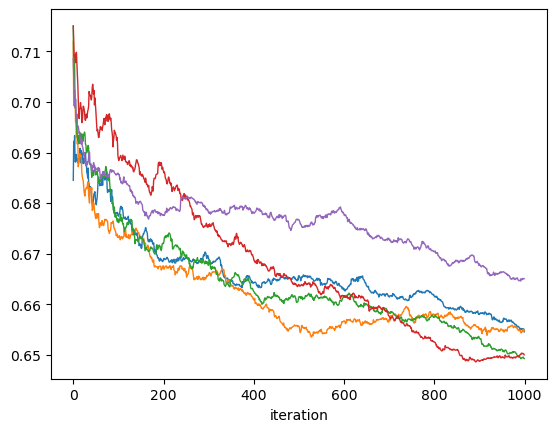

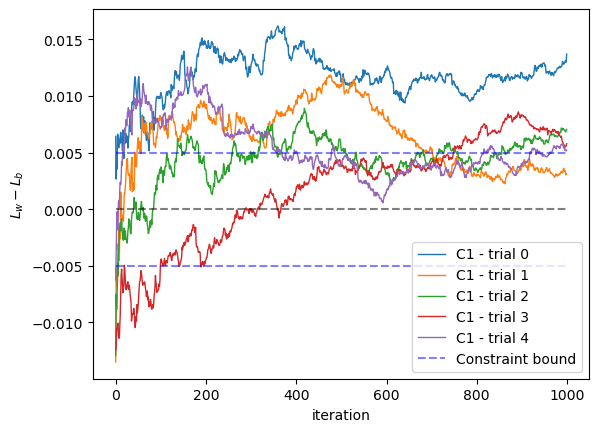

In [370]:
plot_separate_trajectories(stats_test, lb, 'iteration', alpha=1)

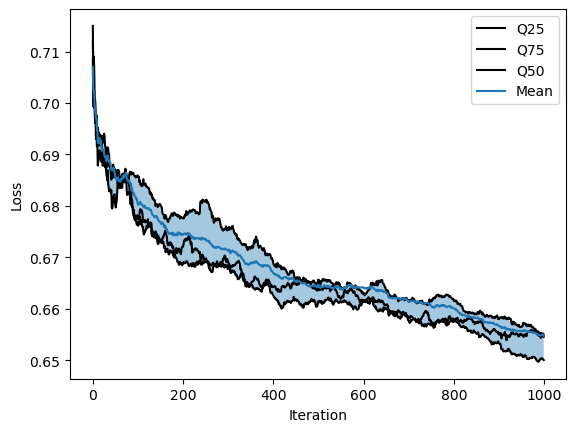

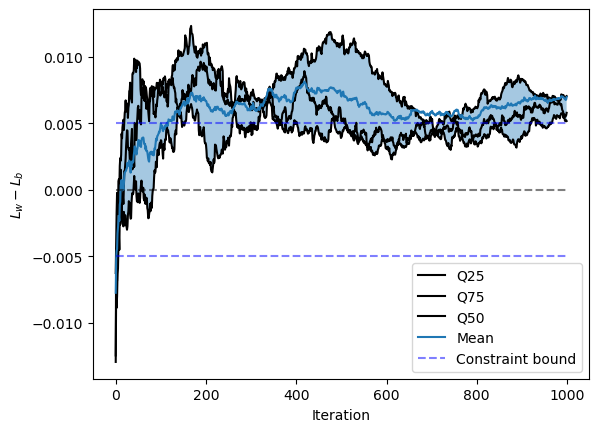

In [371]:
produce_plots(stats_test, lb)

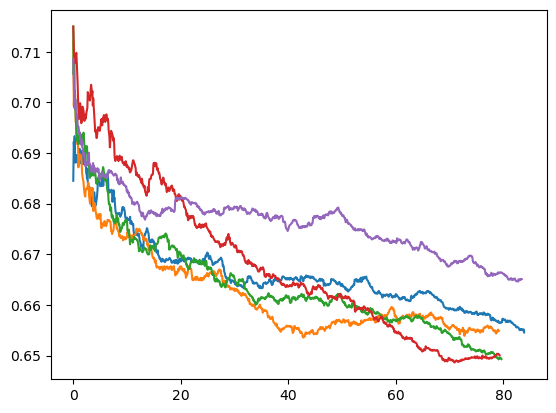

In [372]:
for trial_num in stats_test['trial'].unique():
    plt.plot(stats_test.loc[stats_test['trial'] == trial_num, 'time'], stats_test.loc[stats_test['trial'] == trial_num, 'Loss'])

In [373]:
stats_test.hist(column='CumSampleSize', bins=10000)

KeyError: "None of [Index(['CumSampleSize'], dtype='object')] are in the [columns]"

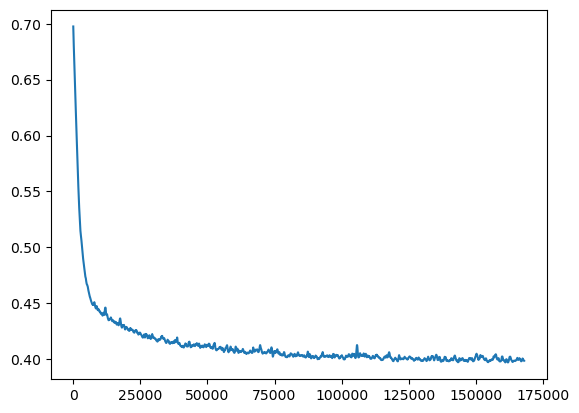

In [ ]:
stats_test['CumSampleSize'] = stats_test.groupby('trial')['SampleSize'].cumsum()
by_css = stats_test.groupby('CumSampleSize')
by_css_mean = by_css.mean()
by_css_qlow = by_css.quantile(q=0,interpolation='lower')
by_css_qupp = by_css.quantile(q=1,interpolation='higher')

f = plt.figure()
ax1 = f.add_subplot()
ax1.plot(by_css_mean['Loss'])

# ax1.fill_between(x=by_css_mean.index.to_numpy(), y1=by_css_qlow['Loss'], y2=by_css_qupp['Loss'],alpha=0.4)
# ax1.plot(by_css_mean.index.to_numpy(), by_css_mean['Loss'])
# ax1.plot(by_css_mean.index.to_numpy(),by_css_qlow['Loss'], c='blue')
# ax1.plot(by_css_mean.index.to_numpy(),by_css_qupp['Loss'],alpha=0.3)